# Using the handcoded data to re-organzied the images into 3 different folders

In [1]:
#Data saved in csv/excel
import glob, os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

https://github.com/cfotache/pytorch_imageclassifier/blob/master/PyTorch_Image_Training.ipynb

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchsampler import ImbalancedDatasetSampler

In [3]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) 

def load_split_train_test(datadir, test):
    train_transforms = transforms.Compose([#transforms.RandomRotation(30),  # data augmentations are great
                                       #transforms.RandomResizedCrop(224),  # but not in this case of map tiles
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor()# case I didn't get good results
                                       ])

    test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor()
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(test, transform=test_transforms)

    trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=collate_fn)
    testloader = torch.utils.data.DataLoader(test_data,  batch_size=128, shuffle=True, collate_fn=collate_fn)
    

    trainloader_b = torch.utils.data.DataLoader(train_data,
    sampler=ImbalancedDatasetSampler(train_data),
    batch_size=128, collate_fn=collate_fn)

    return trainloader, testloader, trainloader_b

In [4]:
data_dir = '/projects/p31410/Gaze_Pytorch/Train/'
test = '/projects/p31410/Gaze_Pytorch/Test/'

trainloader, testloader, trainb = load_split_train_test(data_dir, test)

Dataset: 44739 training samples & 13663 testing samples

Distribution of classes in dataset:


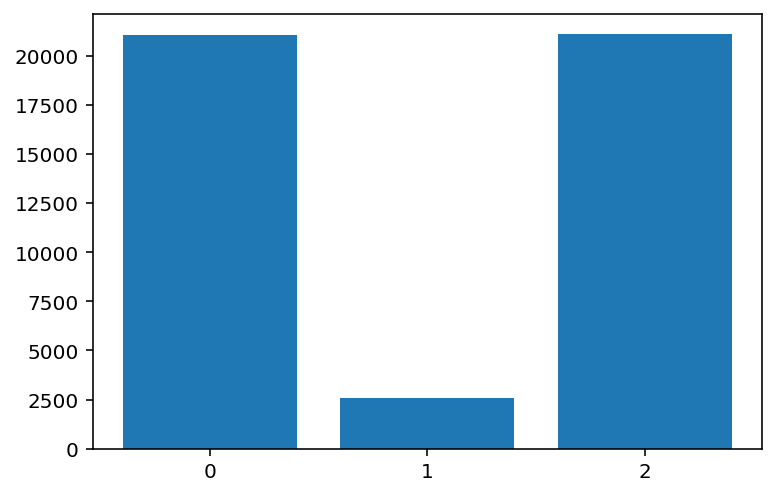

In [5]:
#Overview
print('Dataset: %d training samples & %d testing samples\n' % (
    len(trainloader.dataset), len(testloader.dataset)))
 
print('Distribution of classes in dataset:')
fig, ax = plt.subplots()
labels = [label for _, label in trainloader.dataset.imgs]
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.show()

# Resnet

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
#model = models.resnet34(pretrained=True)

In [111]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear( 512,128),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(128,512),
                                 nn.LogSoftmax(dim=1))
#criterion = nn.NLLLoss()
#optimizer = optim.Adam(model.fc.parameters(), lr=0.003)


criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [112]:
import time 
num_epochs = 2
steps = 0
running_loss = 0
print_every = 20
train_losses, test_losses = [], []
test_acc =[]
since = time.time()
for epoch in range(num_epochs):
    for inputs, labels in trainb:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainb))
            test_losses.append(test_loss/len(testloader))  
            tess_acc.append(100*accuracy/len(testloader))
            print(f"Epoch {epoch+1}/{num_epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {100*accuracy/len(testloader): 2.2f}")
            running_loss = 0
            model.train()
            
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('\rBest test acc = %2.2f%%' % max(test_acc), end='', flush=True)

Epoch 1/2.. Train loss: 5.200.. Test loss: 3.097.. Test accuracy: 0.065
Epoch 1/2.. Train loss: 1.448.. Test loss: 1.186.. Test accuracy: 0.372
Epoch 1/2.. Train loss: 1.089.. Test loss: 1.083.. Test accuracy: 0.353
Epoch 1/2.. Train loss: 1.044.. Test loss: 1.001.. Test accuracy: 0.601
Epoch 1/2.. Train loss: 1.003.. Test loss: 0.989.. Test accuracy: 0.562
Epoch 1/2.. Train loss: 0.985.. Test loss: 0.888.. Test accuracy: 0.686
Epoch 1/2.. Train loss: 0.968.. Test loss: 0.950.. Test accuracy: 0.578
Epoch 1/2.. Train loss: 0.971.. Test loss: 0.982.. Test accuracy: 0.505
Epoch 1/2.. Train loss: 0.950.. Test loss: 0.995.. Test accuracy: 0.418
Epoch 1/2.. Train loss: 0.921.. Test loss: 0.986.. Test accuracy: 0.457
Epoch 1/2.. Train loss: 0.931.. Test loss: 0.892.. Test accuracy: 0.680
Epoch 1/2.. Train loss: 0.946.. Test loss: 1.010.. Test accuracy: 0.417
Epoch 1/2.. Train loss: 0.894.. Test loss: 0.953.. Test accuracy: 0.489
Epoch 1/2.. Train loss: 0.897.. Test loss: 0.888.. Test accuracy

In [113]:
torch.save(model, '/home/tsb7592/Downloads/rmodel_crop.pth')

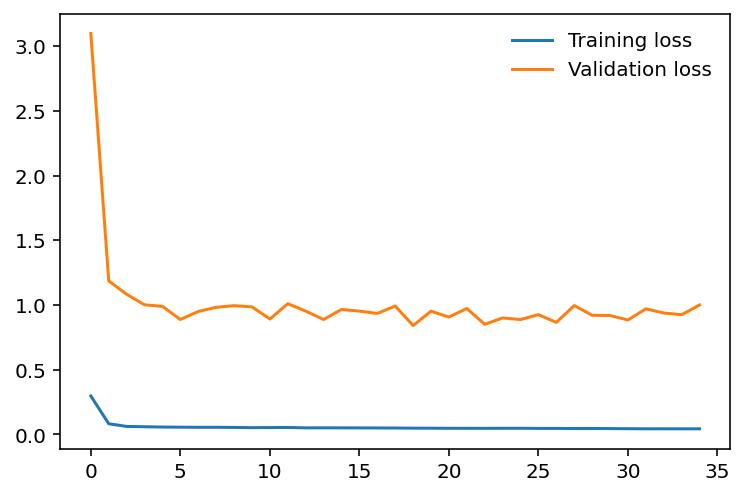

In [114]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# VGG16

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)

n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, 3), nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [44]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,310,147 total parameters.
135,310,147 training parameters.


In [45]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): vgg16

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 3), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if torch.cuda.is_available():
        model = model.to('cuda')

    return model

In [46]:
from torchsummary import summary

In [47]:
model = get_pretrained_model('vgg16')
summary(model, input_size=(3, 224, 224), batch_size=128, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 256, 56, 56]         590,080
             ReLU-14         [128, 256,

In [48]:
print(model.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=3, bias=True)
  (4): LogSoftmax(dim=1)
)


In [49]:
model.idx_to_class = {0:'Away', 1:'Left', 2:'Right'}
list(model.idx_to_class.items())

[(0, 'Away'), (1, 'Left'), (2, 'Right')]

In [50]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [52]:
import time 
num_epochs = 2
steps = 0
running_loss = 0
print_every = 20
train_losses, test_losses = [], []
test_acc =[]
since = time.time()
for epoch in range(num_epochs):
    for inputs, labels in trainb:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainb))
            test_losses.append(test_loss/len(testloader))  
            tess_acc.append(100*accuracy/len(testloader))
            print(f"Epoch {epoch+1}/{num_epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {100*accuracy/len(testloader): 2.2f}")
            running_loss = 0
            model.train()
            
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('\rBest test acc = %2.2f%%' % max(test_acc), end='', flush=True)

Epoch 1/2.. Train loss: 1.064.. Test loss: 0.980.. Test accuracy: 0.305
Epoch 1/2.. Train loss: 0.938.. Test loss: 0.922.. Test accuracy: 0.502
Epoch 1/2.. Train loss: 0.901.. Test loss: 0.993.. Test accuracy: 0.403
Epoch 1/2.. Train loss: 0.879.. Test loss: 0.902.. Test accuracy: 0.546
Epoch 1/2.. Train loss: 0.849.. Test loss: 0.885.. Test accuracy: 0.561
Epoch 1/2.. Train loss: 0.831.. Test loss: 0.850.. Test accuracy: 0.649
Epoch 1/2.. Train loss: 0.801.. Test loss: 0.834.. Test accuracy: 0.630
Epoch 1/2.. Train loss: 0.814.. Test loss: 0.905.. Test accuracy: 0.537
Epoch 1/2.. Train loss: 0.837.. Test loss: 0.831.. Test accuracy: 0.631
Epoch 1/2.. Train loss: 0.784.. Test loss: 0.850.. Test accuracy: 0.612
Epoch 1/2.. Train loss: 0.780.. Test loss: 0.861.. Test accuracy: 0.594
Epoch 1/2.. Train loss: 0.811.. Test loss: 0.858.. Test accuracy: 0.608
Epoch 1/2.. Train loss: 0.775.. Test loss: 0.902.. Test accuracy: 0.567
Epoch 1/2.. Train loss: 0.792.. Test loss: 0.831.. Test accuracy

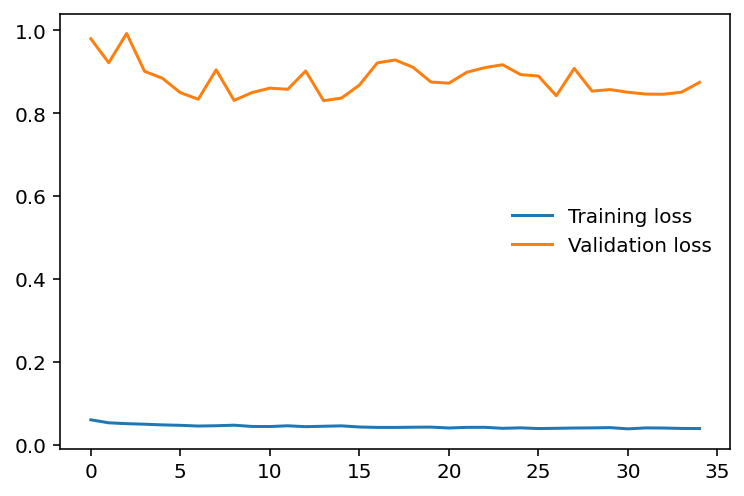

In [53]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [54]:
torch.save(model, '/home/tsb7592/Downloads/vggmodel_crop.pth')

# Validation

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('/home/tsb7592/Downloads/rmodel_crop.pth')
#model.eval()

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index


def get_random_images(num, tdir):
    data = datasets.ImageFolder(tdir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [10]:
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor()
                                      ])

https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def cm(dataloader, string='vgg'):
    nb_classes =3

    confusion_matrix = np.zeros((nb_classes, nb_classes))
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloader):
            inputs = inputs.to(device)
            classes = classes.to(device)        
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    plt.figure(figsize=(10,8))

    target_names= ('Away','Left','Right')
    cm = pd.DataFrame(confusion_matrix, index=target_names, columns=target_names).astype(int)
    
    # Normalise
    cmn = 100* cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    if string == 'vgg':
        heatmap = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
    else:
        heatmap = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap='Greens')
   
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)



# Validation ResNet

In [6]:
female = '/projects/p31410/Gaze_Pytorch/Test_female/'
male = '/projects/p31410/Gaze_Pytorch/Test_male/'

_, testloader_female ,_= load_split_train_test(data_dir, female)
testloader_female.dataset

Dataset ImageFolder
    Number of datapoints: 5034
    Root location: /projects/p31410/Gaze_Pytorch/Test_female/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [7]:
_, testloader_male ,_= load_split_train_test(data_dir, male)
testloader_male.dataset

Dataset ImageFolder
    Number of datapoints: 8629
    Root location: /projects/p31410/Gaze_Pytorch/Test_male/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

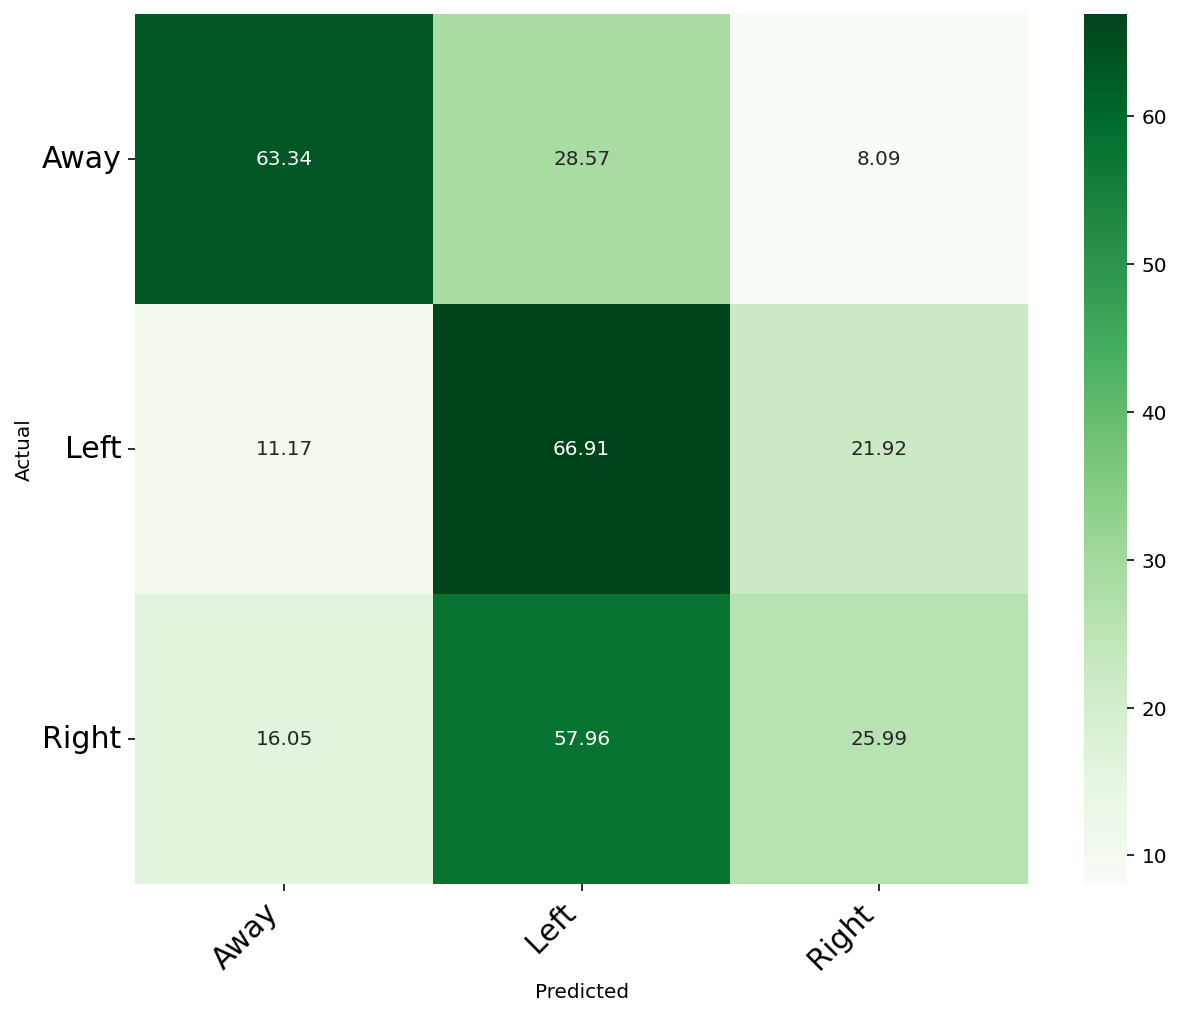

In [14]:
#All testset validation
cm(testloader, 'resnet')

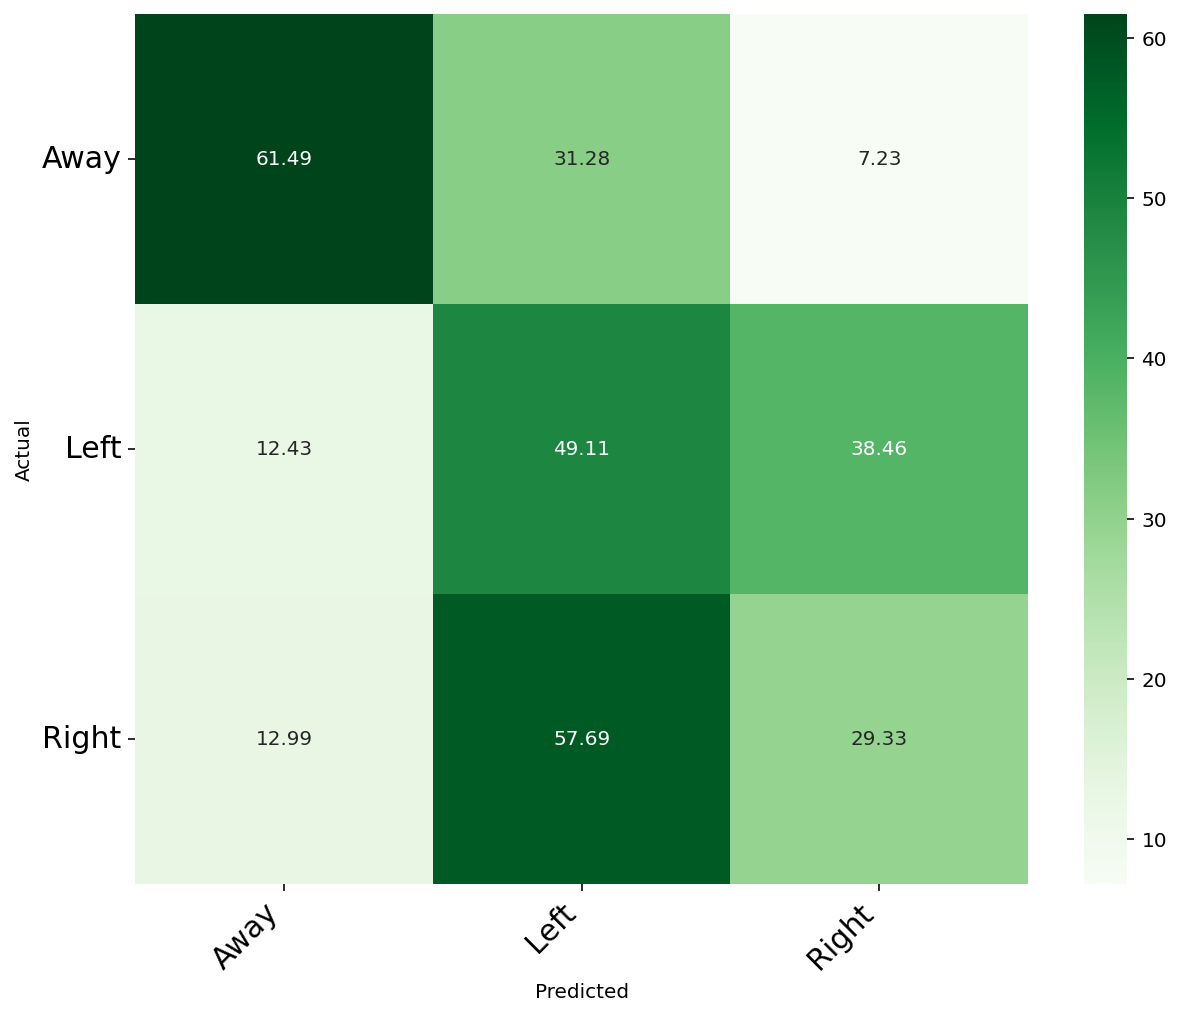

In [15]:
#Female validation
cm(testloader_female, 'resnet')

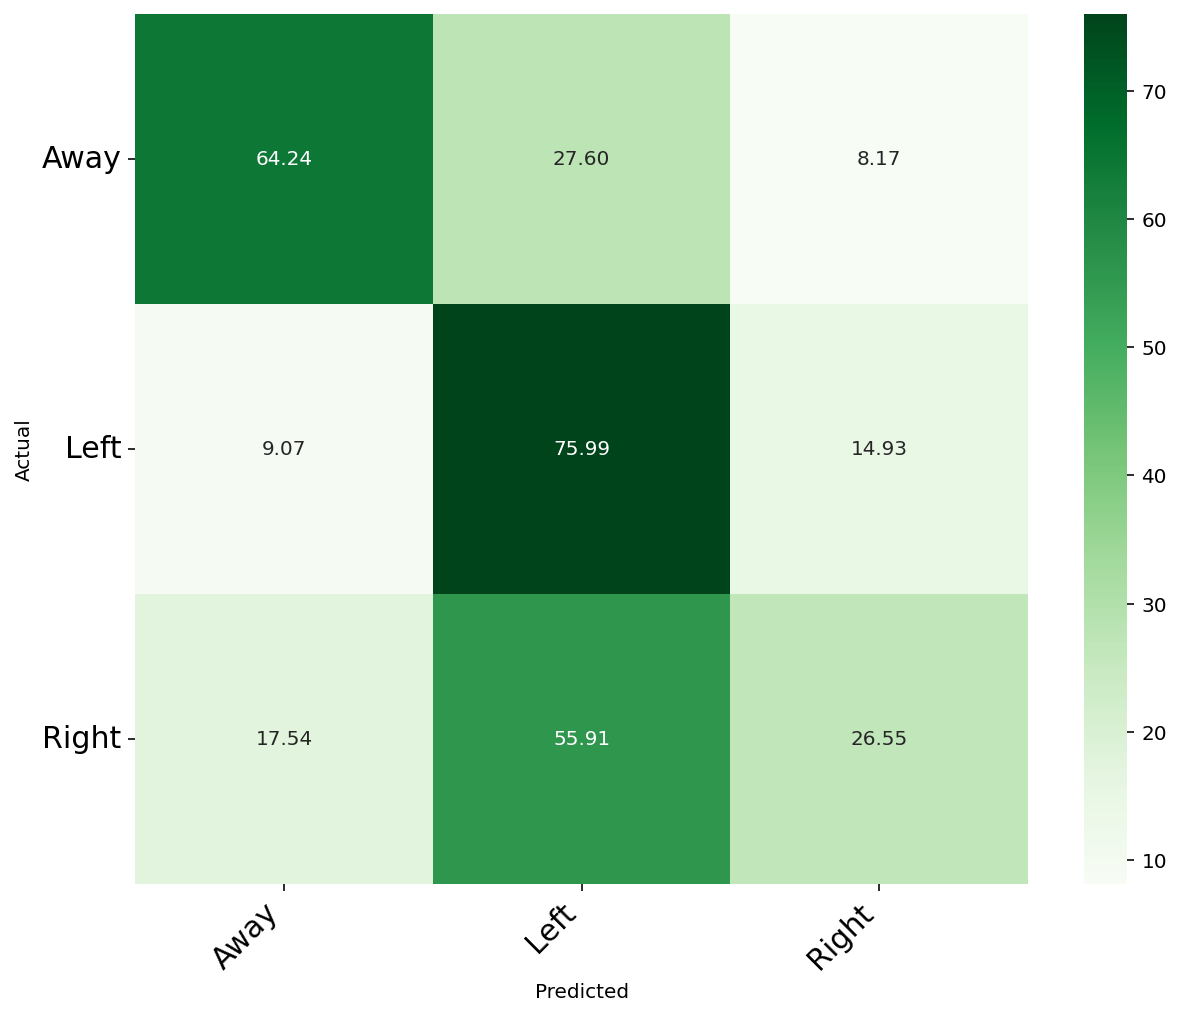

In [16]:
#Male validation
cm(testloader_male, 'resnet')

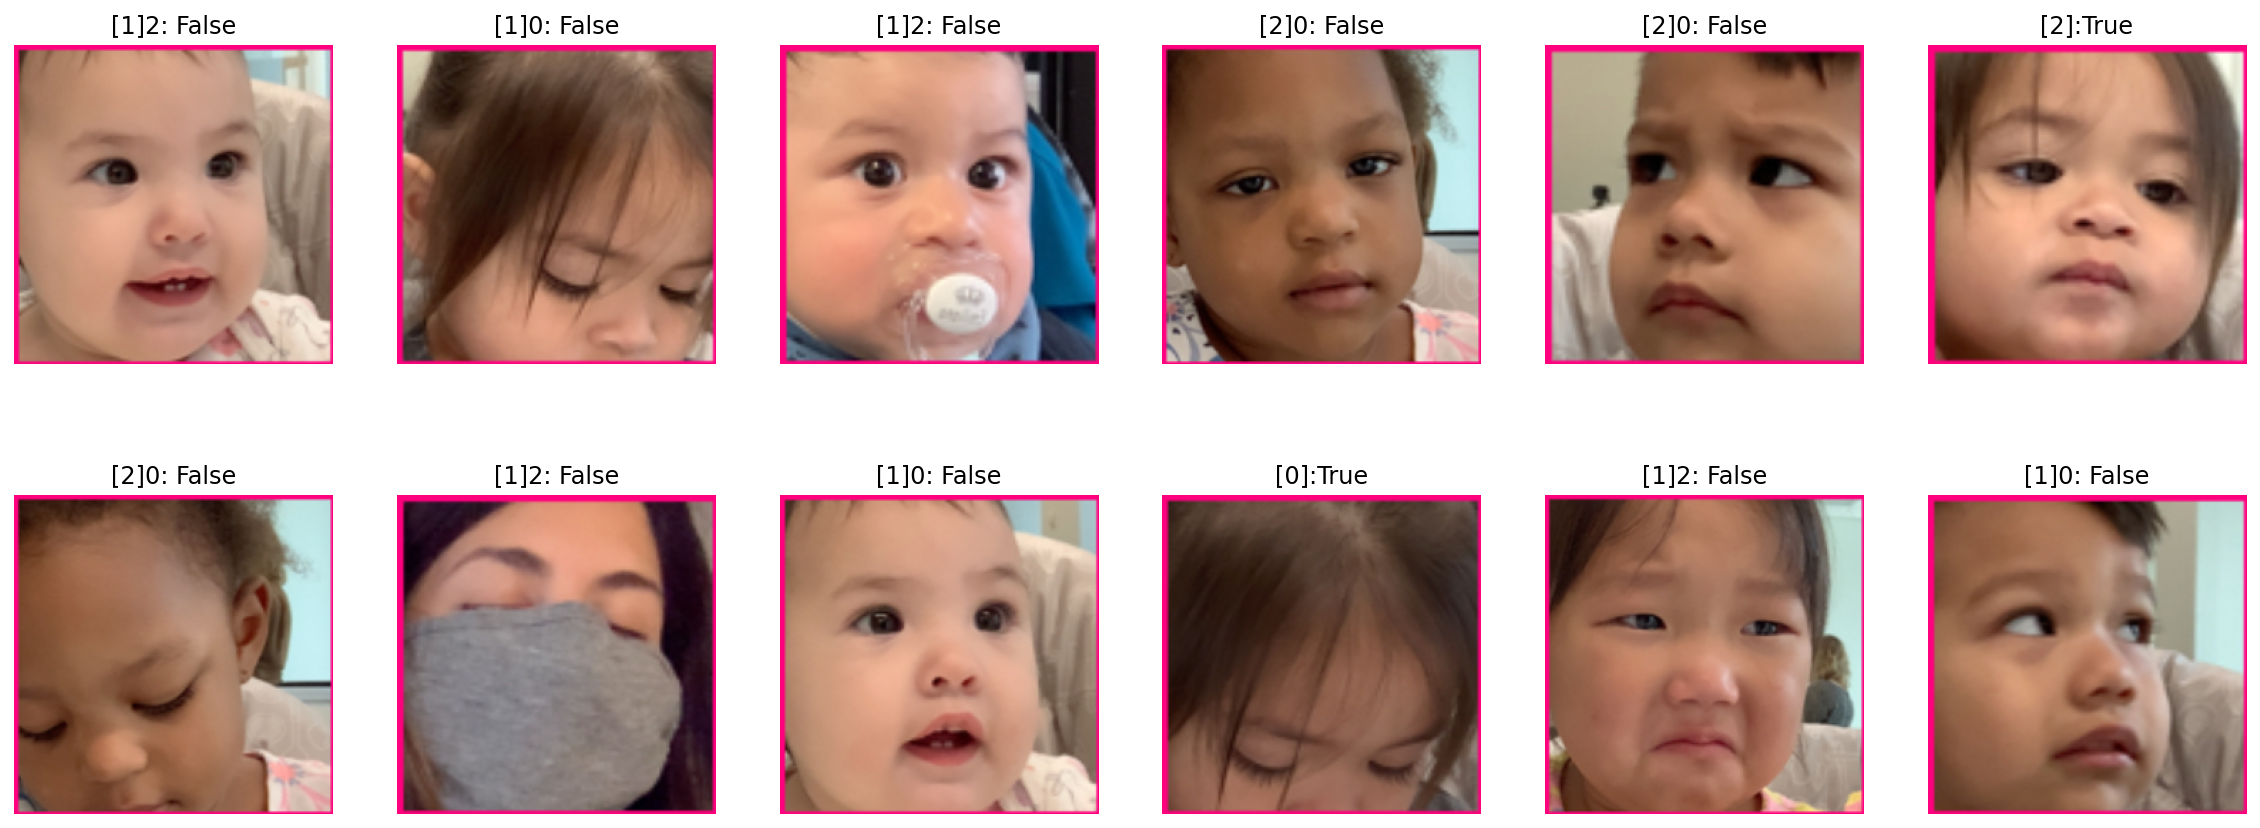

In [17]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(12, test)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(5, 6, ii+1)
    res = int(labels[ii]) == index
    if not res:
        sub.set_title(str([index]) + str(int(labels[ii]))+": " + str(res))
    else:
        sub.set_title(str([index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()


# Validation VGG

In [79]:
tcm

,Away,Left,Right
Away,3560,799,1584
Left,103,256,339
Right,1243,1994,3785


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('/home/tsb7592/Downloads/vggmodel_crop.pth')
#model.eval()

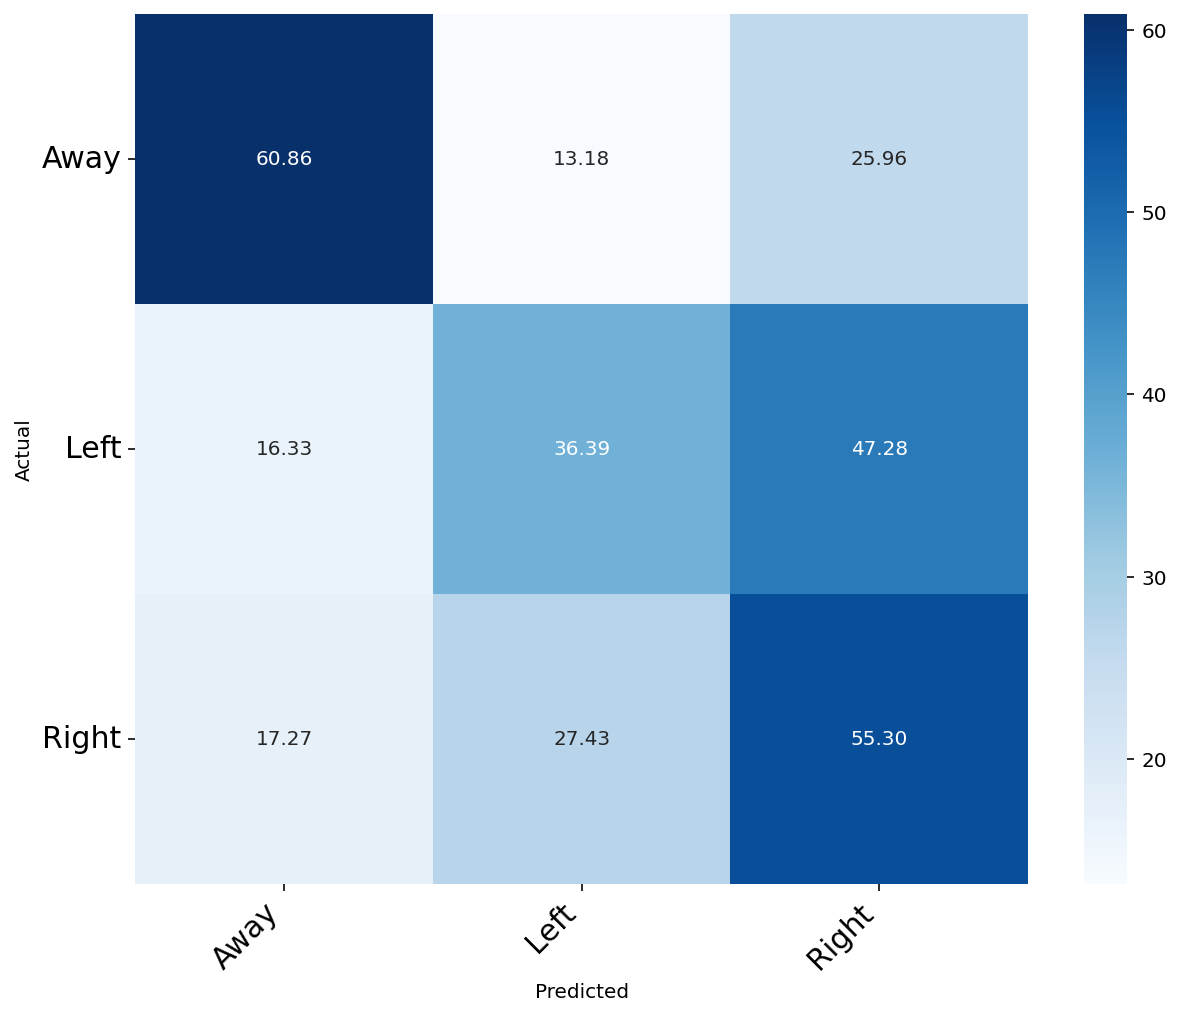

In [19]:
#all test data
cm(testloader)

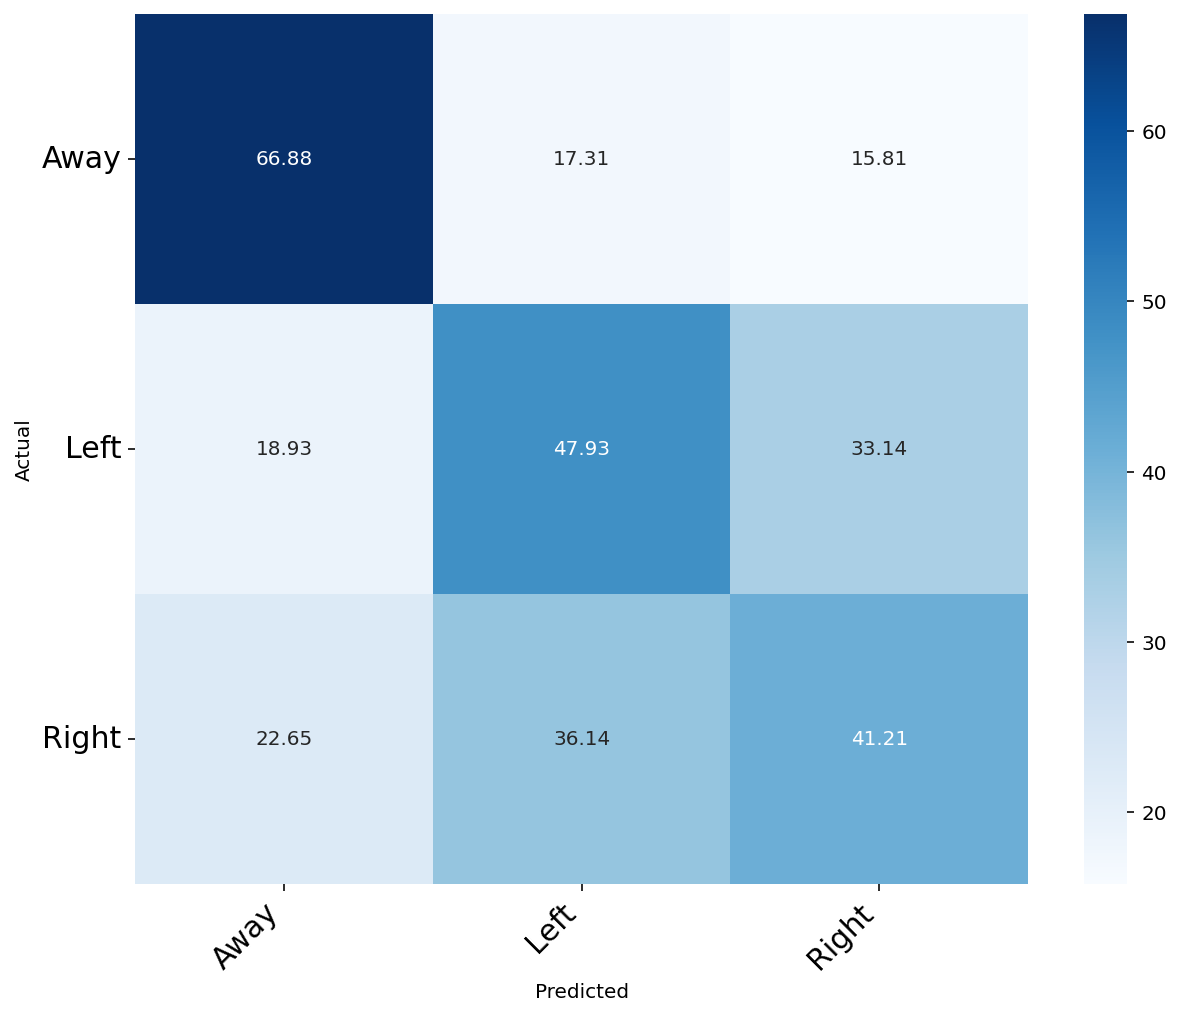

In [20]:
cm(testloader_female)

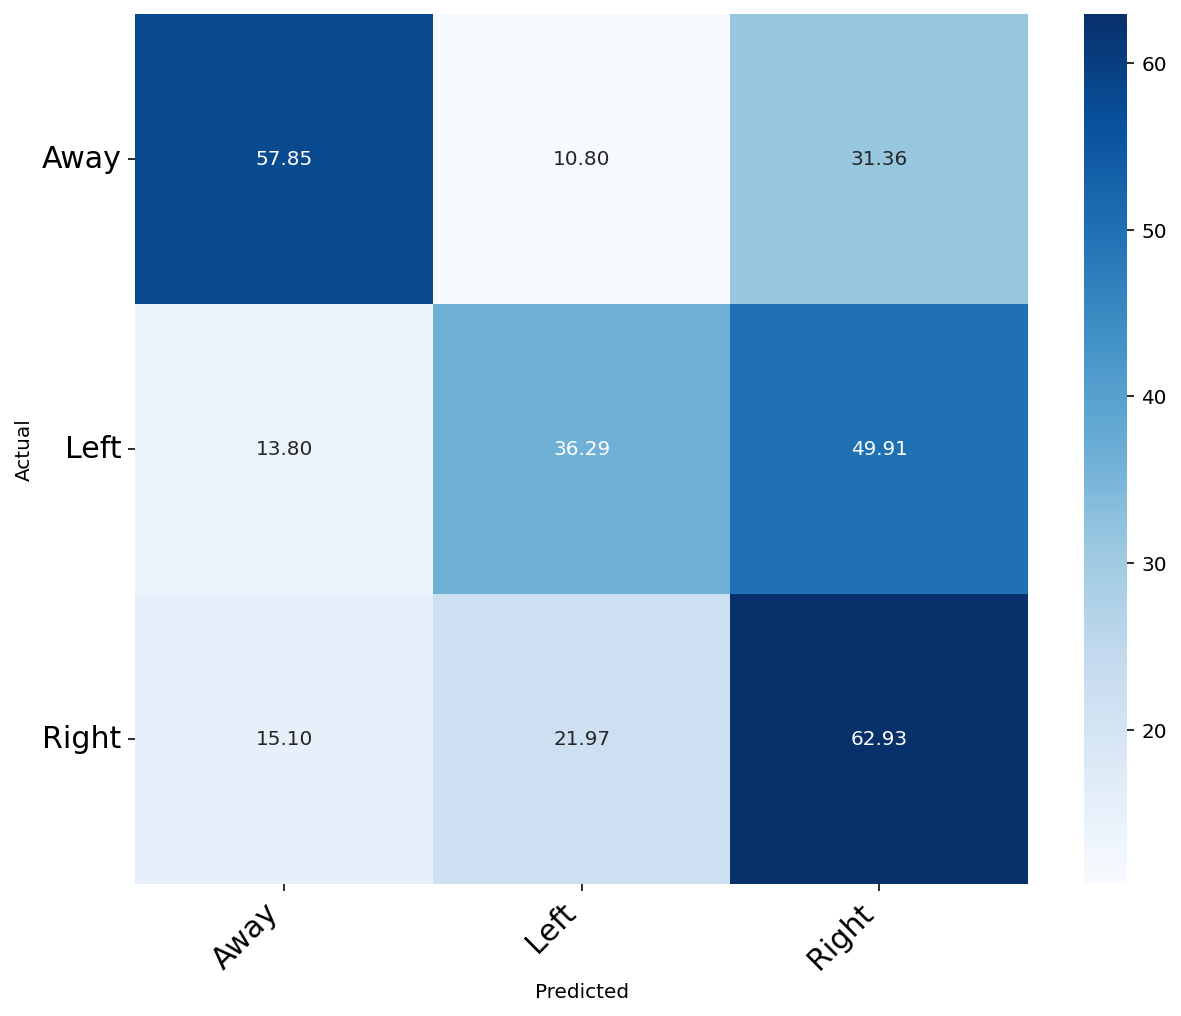

In [21]:
cm(testloader_male)

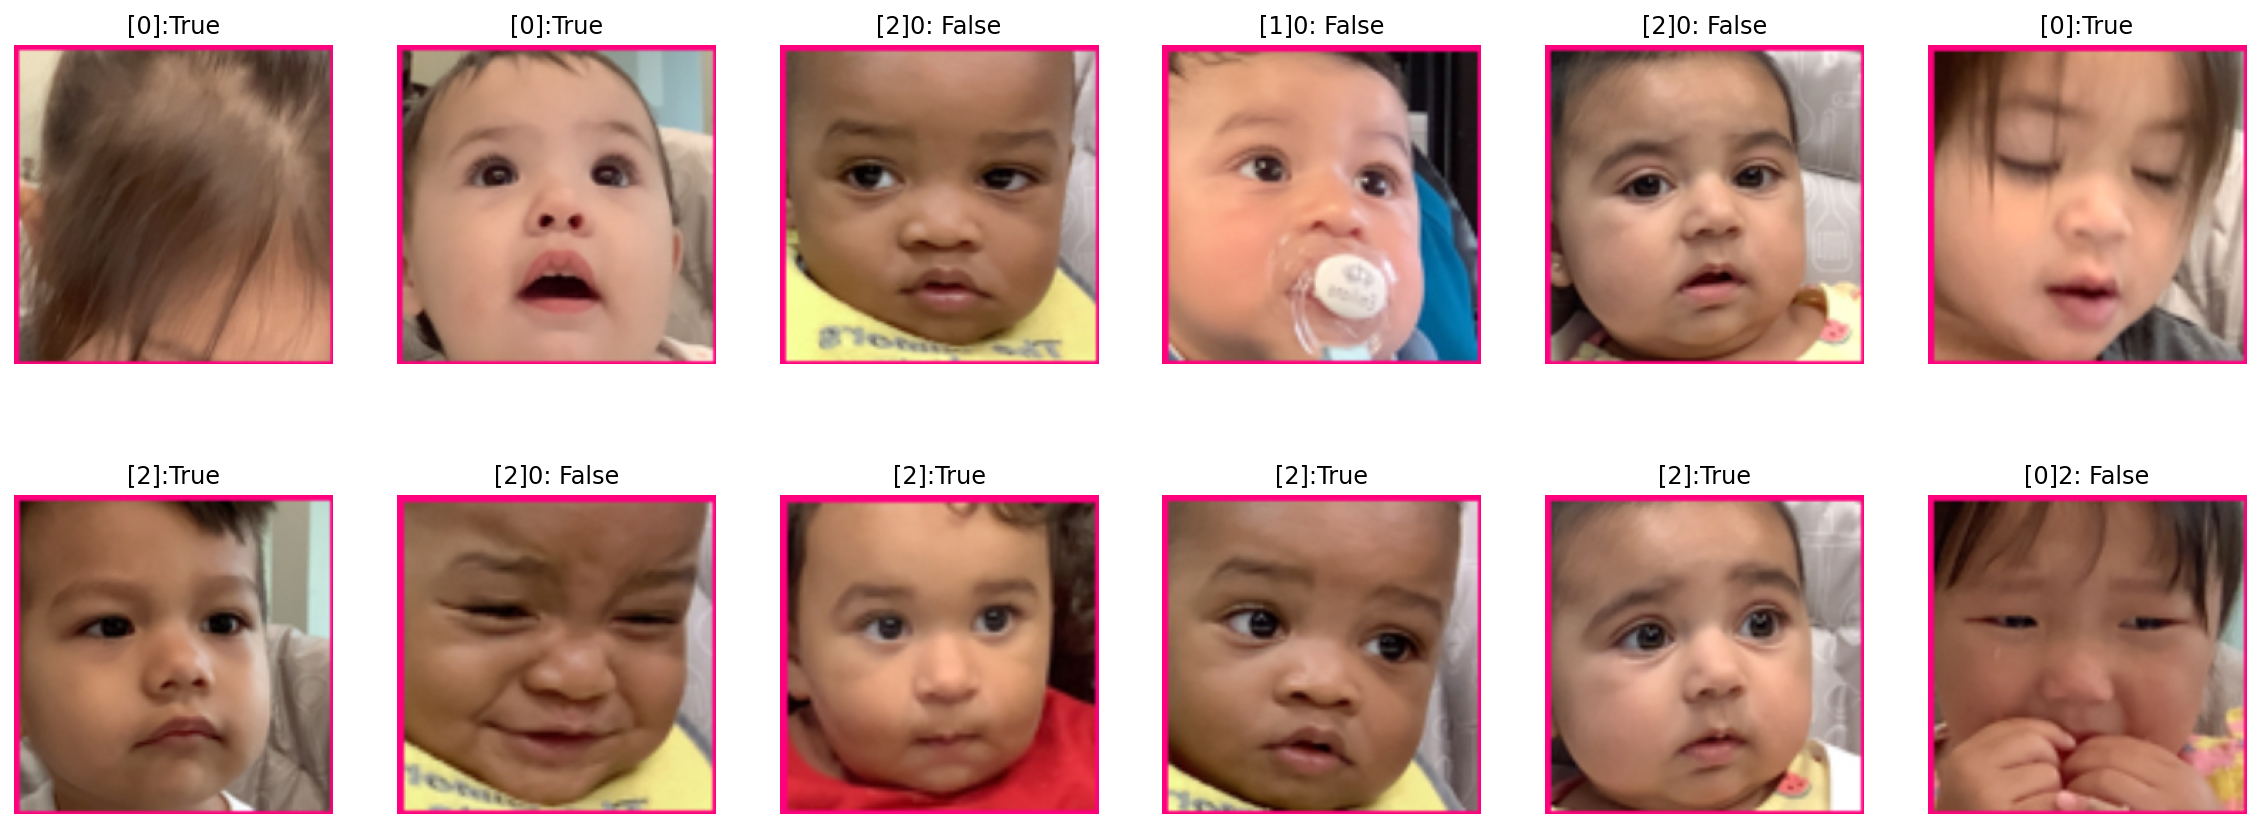

In [23]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(12, test)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(5, 6, ii+1)
    res = int(labels[ii]) == index
    if not res:
        sub.set_title(str([index]) + str(int(labels[ii]))+": " + str(res))
    else:
        sub.set_title(str([index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()
